In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [2]:
# Load the data
data = pd.read_excel("default_of_credit_card_clients.xls")

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64


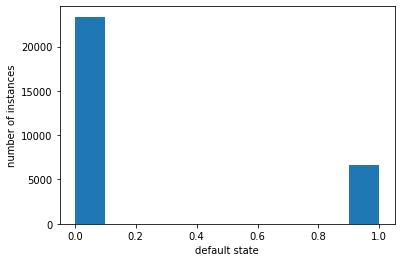

Running Support Vector Machine...


No handles with labels found to put in legend.


Support Vector Machine
best_params
measure:  accuracy, value : 0.8205
measure:  precision, value : 0.8033282430542946
measure:  recall, value : 0.8205
measure:  f1_score, value : 0.7959038159472653
measure:  fit_time, value : 104.78501453399659
measure:  score_time, value : 12.414695358276369


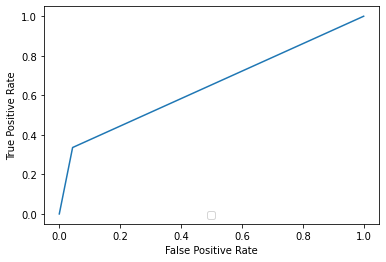

In [3]:
columns = data.iloc[0]
val_0 = list(columns.values)
data.set_axis(val_0, axis=1, inplace=True)
data.drop(0, inplace = True)

# Check for missing values
print(data.isnull().sum())

# Check for outliers
plt.hist(data['default payment next month'])
plt.xlabel('default state')
plt.ylabel('number of instances')
plt.show()

###

#Creation of dummy variable by hand
#Creation of dummy variables
L = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
for column in L:  
    for type in data[f"{column}"].unique():
        data[f"{column}_{type}"] = np.where(data[f"{column}"] == type,1,0)
    data.drop(columns=[f"{column}"], inplace=True)

# Age
for i in range(15,86,5):
    data[f"AGE_{i}_{i+5}"] = np.where((data["AGE"] >= i) & (data["AGE"] < i+5), 1,0)
data.drop(columns=["AGE"], inplace=True)

#Bill column
for i in range(1,7):
    data[f"BILL_AMT{i}"] = (data[f"BILL_AMT{i}"] - data[f"BILL_AMT{i}"].mean())/data[f"BILL_AMT{i}"].std()

#Pay column
for i in range(1,7):
    data[f"BILL_AMT{i}"] = (data[f"PAY_AMT{i}"] - data[f"PAY_AMT{i}"].mean())/data[f"PAY_AMT{i}"].std()

#data.drop(columns=["ID","SEX", "EDUCATION", "MARRIAGE", 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'],inplace=True)
val = list(columns.values)

#labels = np.array(data['default payment next month'])
#labels = labels.astype('int')
#features = data.drop('default payment next month', axis = 1)
#features_list = val
#features = np.array(features)
x = data.drop('default payment next month', axis=1)
y = data['default payment next month'].astype('int')
#train_features, test_features, train_label, test_label = train_test_split(features, labels, test_size = 0.33, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

###

# Scale the data
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

# Define the classifiers and their parameter grids
classifiers = {
    #'Random Forest': (RandomForestClassifier(),
                      #{'n_estimators': [50, 100, 200],
                       #'criterion': ['gini', 'entropy'],
                       #'max_depth': [2, 4, 6, 8, 10]}),
    'Support Vector Machine': (SVC(),
                               {'C': [0.01, 0.1, 1, 10, 100],
                                'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                                'degree': [2, 3, 4],
                                'gamma': ['scale', 'auto']}),
    
    #'XGBoost': (XGBClassifier(),
                #{'learning_rate': [0.01, 0.1, 0.5],
                 #'max_depth': [2, 4, 6, 8, 10],
                 #'n_estimators': [50, 100, 200]})
}

# Train and evaluate the classifiers
results = {}
for name, (classifier, param_grid) in classifiers.items():
    print(f'Running {name}...')
    grid_search = GridSearchCV(classifier, param_grid=param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    results[name] = {
        'best_params': grid_search.best_params_,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='weighted'),
        'recall': recall_score(y_test, y_pred, average='weighted'),
        'f1_score': f1_score(y_test, y_pred, average='weighted'),
        'fit_time': grid_search.cv_results_['mean_fit_time'].mean(),
        'score_time': grid_search.cv_results_['mean_score_time'].mean()
    }
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower center')

# Print the results
for name, result in results.items():
    print(name)
    for measure, value in result.items():
        if measure != 'best_params':
            print(f'measure:  {measure}, value : {value}')
        else:
            print(measure)
